Trevor is working on truly periodic boundary conditions for BM1a. He wanted to test it using a spectral method.  

[Current notebook that I thought actually worked](https://gist.github.com/wd15/ce3c8620fd19ba58f80e4f35da562dda#file-upload_demo-ipynb)

It doesn't. There is something wrong with the transformation between the two equations.

## Equation for -1 to 1 $\phi$

Free energy:

$$ f = \frac{1}{4} \left( 1 - \phi \right)^2 \left(1 +\phi 
\right)^2 $$
Base equation:

$$ \dot{\phi} = \nabla^2 \left[ \frac{\partial f}{\partial \phi} \right]
 - \gamma \nabla^4 \phi $$ 
becomes
 
 $$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi$$

## Equation from benchmark


$$ \dot{c} = \nabla \cdot \left\{ M \nabla \left(  \frac{\partial f_{\text{chem}}}{\partial c} - \kappa\nabla^2 c \right) \right\}  $$

with

$$ f_{\text{chem}} = \rho_s \left(c - c_{\alpha} \right)^2 \left(c - c_{\beta} \right)^2 $$

## How to transform between the equations



Use the following transformations
$$ c = \frac{1}{2}\left(c_{\beta} - c_{\alpha} \right) \left( 1 + \phi \right) + c_{\alpha} $$
and 
$$ t = \tilde{t} \tau $$
Note that $\tau$ is the new time scale and $\tilde{t}$ is the transformation constant

With this transformation,

$$ \frac{\partial f_{\text{chem}}}{\partial c} = \frac{\rho_s}{2} \left( c_{\beta} - c_{\alpha} \right)^3 \left( \phi^3 - \phi \right) $$

after substitution. The benchmark equation then becomes,

$$ \frac{1}{\tilde{t} M \rho_s       \left( c_{\beta} - c_{\alpha} \right)^2 } \dot{\phi} =                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       \nabla^2 \left( \phi^3 - \phi \right)  - \frac{\kappa}{\left( c_{\beta} - c_{\alpha} \right)^2 \rho_s } \nabla^4 \phi$$

So to make this work, we need to choose

$$ \tilde{t} = \frac{1}{M \rho_s       \left( c_{\beta} - c_{\alpha} \right)^2 } $$

That's our time scale transformation between pymks and the benchmark problem. Also $\gamma$ is chosen to be

$$ \gamma = \frac{\kappa}{\left( c_{\beta} - c_{\alpha} \right)^2 \rho_s } $$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymks import solve_cahn_hilliard
import pandas
import dask.array as da
from pymks.fmks.func import curry

In [2]:
c_alpha = 0.3
c_beta = 0.7
M = 5
kappa = 2
rho_s = 5
dx = 1.

In [3]:
gamma = kappa / (c_beta - c_alpha)**2 / rho_s

In [4]:
def get_conc_time(time):
    return time /  M / rho_s / (c_beta - c_alpha)**2

In [5]:
def get_phi_time(bench_t):
    return bench_t / get_conc_time(1.)

In [6]:
def get_conc(phi):
    return (1 + phi) * (c_beta - c_alpha) / 2 + c_alpha

In [7]:
def get_phi(conc):
    return 2 * (conc - c_alpha) / (c_beta - c_alpha) - 1

In [8]:
initial_conc = lambda x, y: 0.5 + 0.01 * (np.cos(0.105 * x) * np.cos(0.11 * y) + (np.cos(0.13 * x) * np.cos(0.087 * y))**2 \
                                          + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))

xx = np.linspace(dx / 2, 200 - dx / 2, 200)
x, y = np.meshgrid(xx, xx)
phi_ini = get_phi(initial_conc(x, y))

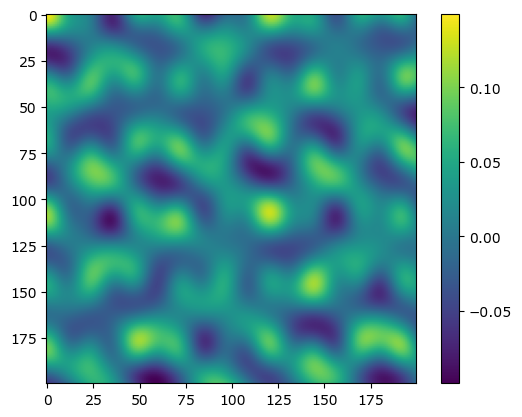

In [9]:
plt.imshow(phi_ini)
plt.colorbar()

In [21]:
dt_conc = 0.25

dt_phi = get_phi_time(dt_conc)

phi = np.reshape(phi_ini, (1, 200, 200))

#x_data = da.from_array(x_data, chunks=(1, 200, 200))
solve_ = curry(solve_cahn_hilliard)
solve = solve_(n_steps=1, delta_x=dx, gamma=gamma)

for _ in range(1000):
    phi = solve(phi, delta_t=dt_phi).compute()

In [22]:
print(dt_phi)

0.9999999999999998


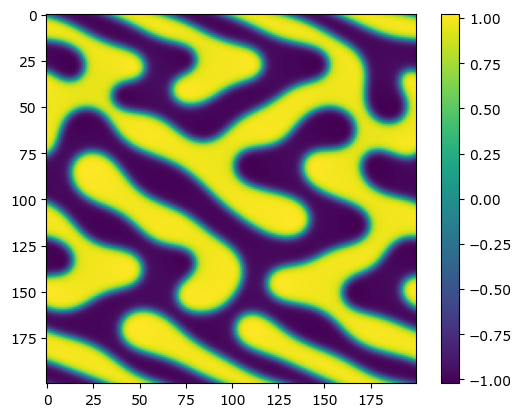

In [23]:
plt.imshow(phi[0])
plt.colorbar()

In [24]:
def f_chem(conc):
    return rho_s * (conc - c_alpha)**2 * (conc - c_beta)**2

def calc_grad_mag_sq(conc):
    cx = np.concatenate((conc[-1:, :], conc, conc[:1, :]), axis=0)
    cy = np.concatenate((conc[:, -1:], conc, conc[:, :1]), axis=1)
    c_x = (cx[2:, :] - cx[:-2, :]) / 2 / dx
    c_y = (cy[:, 2:] - cy[:, :-2]) / 2 / dx
    return np.sum((c_x**2 + c_y**2))
    
def calc_f_total(phi, dx, kappa):
    conc = get_conc(phi)
    return (np.sum(f_chem(conc)) + 0.5 * kappa * calc_grad_mag_sq(conc)) * dx**2
    
def run(timesteps, dt_conc):
    dt_phi = get_phi_time(dt_conc)
    phi = get_phi(initial_conc(x, y)).reshape((1, 200, 200))
    time_energy = []
    elapsed_time = 0.0
    for step in range(timesteps):
        phi = solve(phi, delta_t=dt_phi).compute()
        time_energy.append([dt_conc * step, 
                            calc_f_total(phi, dx, kappa)])
        
    return np.array(time_energy)   

In [30]:
time_energy0 = run(10000, 1.0)
time_energy1 = run(10000, 0.5)
time_energy2 = run(10000, 0.25)

In [33]:
time_energy2[0]

array([  0.        , 319.00342259])

In [35]:
time_energy2[-1]

array([2499.75      ,   47.97997337])

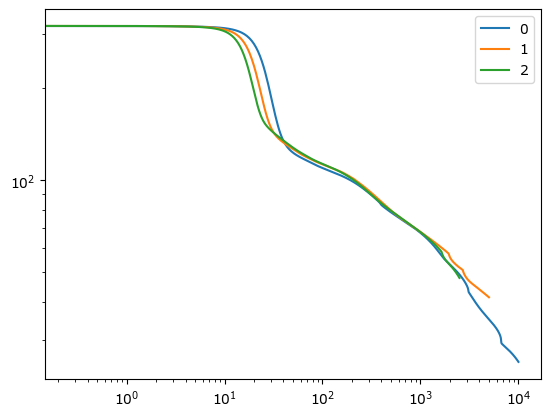

In [32]:
plt.loglog(time_energy0[:, 0], time_energy0[:, 1], label='0')
plt.loglog(time_energy1[:, 0], time_energy1[:, 1], label='1')
plt.loglog(time_energy2[:, 0], time_energy2[:, 1], label='2')
plt.legend()

In [41]:
%timeit run(1000)

5.48 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print("simulation time: 1000s, wall time: 5.48s")

simulation time: 1000s, wall time: 5.48s


In [10]:
%load_ext memory_profiler

%memit run(1000)

peak memory: 280.29 MiB, increment: 4.48 MiB


In [14]:
print("memory used (value for upload):", 289.29 * 1024)

memory used (value for upload): 296232.96
